In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [7]:
# Read the CSV file 
df = pd.read_csv('NDVI.csv')

# Print the DataFrame
print(df)

         id    year   NDVI_08   NDVI_09   NDVI_10   NDVI_11   NDVI_12  \
0       1.0  2019.0  0.191540  0.181471  0.159935  0.374889  0.873755   
1       1.0  2020.0  0.203258  0.135215  0.129017  0.304074  0.709940   
2       1.0  2021.0  0.169163  0.139298  0.176505  0.324717  0.785839   
3       1.0  2022.0  0.122308  0.117480  0.127501  0.161553  0.620289   
4       2.0  2019.0  0.189737  0.194818  0.171174  0.490688  0.904467   
...     ...     ...       ...       ...       ...       ...       ...   
3195  799.0  2022.0  0.123714  0.117433  0.117978  0.434029  0.555517   
3196  800.0  2019.0  0.202469  0.194453  0.197959  0.619619  0.863051   
3197  800.0  2020.0  0.177476  0.176527  0.168000  0.424272  0.780884   
3198  800.0  2021.0  0.160505  0.145747  0.200651  0.810300  0.040291   
3199  800.0  2022.0  0.126200  0.122546  0.118038  0.433724  0.605364   

       NDVI_01   NDVI_02   NDVI_03   NDVI_04   NDVI_05   NDVI_06   NDVI_07  \
0     0.890306  0.427724  0.265450  0.845153 

In [8]:
df['Cover_crop'].replace('double_cover', 'double', inplace=True)
unique_classes = df['Cover_crop'].unique()

print("Unique classes in the 'Cover_crop' variable:")
for cls in unique_classes:
    print(cls)

Unique classes in the 'Cover_crop' variable:
double
single
cover


In [9]:
# Separate features (X) and target (y)
X = df.drop(columns=['Cover_crop'])
y = df['Cover_crop']

# Split data into training and test sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
train_y_encoded = label_encoder.fit_transform(train_y)
test_y_encoded = label_encoder.transform(test_y)

# Check class imbalance before applying SMOTE
print("Before applying SMOTE:")
print("Class distribution in train_y:")
print(train_y.value_counts())

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
train_X_resampled, train_y_resampled = smote.fit_resample(train_X, train_y_encoded)

# Check class distribution after applying SMOTE
print("\nAfter applying SMOTE:")
print("Class distribution in train_y_resampled:")
print(pd.Series(train_y_resampled).value_counts())

Before applying SMOTE:
Class distribution in train_y:
Cover_crop
double    1849
cover      323
single      68
Name: count, dtype: int64

After applying SMOTE:
Class distribution in train_y_resampled:
1    1849
0    1849
2    1849
Name: count, dtype: int64


In [10]:
# Initialize the model
rf_model = RandomForestClassifier()

# Fit the model to the training data
rf_model.fit(train_X_resampled, train_y_resampled)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search
rf_grid = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=10, n_jobs=-1)
rf_grid.fit(train_X_resampled, train_y_resampled)

# Get best hyperparameters
best_params = rf_grid.best_params_

# Evaluate model using cross-validation
cv_scores = cross_val_score(rf_model, train_X_resampled, train_y_resampled, cv=10, scoring='accuracy')
mean_cv_accuracy = cv_scores.mean()

In [11]:
# Predictions on test set
test_preds = rf_model.predict(test_X)

# Calculate metrics
accuracy = accuracy_score(test_y_encoded, test_preds)
f1 = f1_score(test_y_encoded, test_preds, average='weighted')
recall = recall_score(test_y_encoded, test_preds, average='weighted')
precision = precision_score(test_y_encoded, test_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(best_params)

Accuracy: 0.8688
F1 Score: 0.8689
Recall: 0.8688
Precision: 0.8691
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


Default labels

Class Labels:
0
1
2


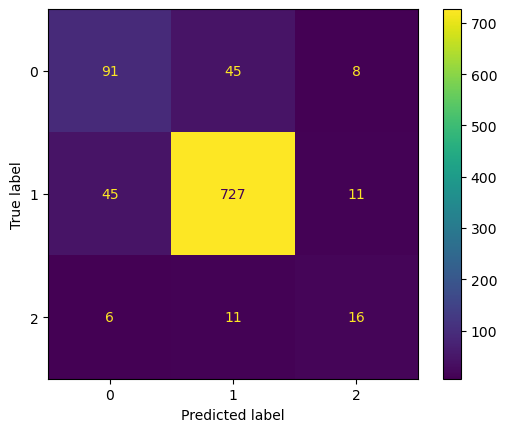

In [12]:
print("Default labels")
print("")

class_labels = rf_model.classes_

print("Class Labels:")
for label in class_labels:
    print(label)

cmBasic1 = confusion_matrix(test_y_encoded, test_preds, labels = rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cmBasic1)
disp.plot()
plt.show()

# class 0 = cover crop
# class 1 = double crop
# class 2 = single crop